# QGS model: MAOSOAM

## Coupled ocean-atmosphere channel model version

This model version is a 2-layer channel QG atmosphere truncated at wavenumber 2 coupled, both by friction and heat exchange, to a shallow water **channel** ocean also truncated at wavenumber 2. 

More details can be found in the articles:
*  Vannitsem, S., Solé‐Pomies, R. and De Cruz, L. (2019). *Routes to long‐term atmospheric predictability in reduced‐order coupled ocean–atmosphere systems ‐ Impact of the ocean basin boundary conditions.* Quarterly Journal of the Royal Meteorological Society, **145**: 2791– 2805. [doi.org/10.1002/qj.3594](https://doi.org/10.1002/qj.3594)
* Vannitsem, S., Demaeyer, J., De Cruz, L., & Ghil, M. (2015). *Low-frequency variability and heat transport in a low-order nonlinear coupled ocean–atmosphere model*. Physica D: Nonlinear Phenomena, **309**, 71-85. [doi:10.1016/j.physd.2015.07.006](https://doi.org/10.1016/j.physd.2015.07.006)
* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). *The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0*, Geosci. Model Dev., **9**, 2793-2808. [doi:10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016)

or in the documentation and on [readthedocs](https://qgs.readthedocs.io/en/latest/files/model/maooam_model.html).

## Modules import

First, setting the path and loading of some modules

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../')])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [4]:
np.random.seed(210217)

Importing the model's modules

In [5]:
from qgs.params.params import QgParams
from qgs.basis.fourier import contiguous_channel_basis
from qgs.integrators.integrator import RungeKuttaIntegrator
from qgs.functions.tendencies import create_tendencies

## Systems definition

General parameters

In [6]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 100

number_of_trajectories = 1

Setting some model parameters

In [7]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams({'n': 1.5})

# Mode truncation at the wavenumber 2 in both x and y spatial
# coordinates for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2, mode="symbolic")
# Mode truncation at the wavenumber 2 in the x and at the 
# wavenumber 4 in the y spatial coordinates for the ocean
ocean_basis = contiguous_channel_basis(2, 2, 1.5)
model_parameters.set_oceanic_modes(ocean_basis)

In [8]:
# Setting MAOOAM parameters according to the publication linked above
model_parameters.set_params({'phi0_npi': 0.3056, 'kd': 0.026778245344758034, 'kdp': 0.026778245344758034, 'r': 1.e-8,
                             'h': 1000.0, 'd': 1.6e-8, 'f0': 1.195e-4, 'sigma': 0.14916, 'n':1.7})
model_parameters.atemperature_params.set_params({'eps': 0.76, 'T0': 270.,
                                                 'hlambda': 16.064})
model_parameters.gotemperature_params.set_params({'gamma': 4e9, 'T0': 285.})

Setting the short-wave radiation component as in the publication above: $C_{\text{a},1}$ and $C_{\text{o},1}$ 


In [9]:
model_parameters.atemperature_params.set_insolation(350/3., 0)
model_parameters.gotemperature_params.set_insolation(350, 0)

Printing the model's parameters

In [10]:
model_parameters.print_params()

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001195  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.7    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.3056    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.026778245344758034  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.026778245344758034  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.14916  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 116.66666666666667  [W][m^-2]  (spe

Creating the tendencies function

In [11]:
%%time
## Might take several minutes, depending on the number of cpus you have.
f, Df = create_tendencies(model_parameters)

/home/scratch01/gmiloshe/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +
/home/scratch01/gmiloshe/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +
/home/scratch01/gmiloshe/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +
/home/scratch01/gmiloshe/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  wa

CPU times: user 15.2 s, sys: 1.83 s, total: 17 s
Wall time: 25.7 s


## Time integration

Defining an integrator

In [12]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start from an initial condition on the attractors obtained after a long transient integration time 

In [13]:
ic = np.array([ 2.34980646e-02, -5.91652353e-03,  3.20923307e-03, -1.08916714e-03,
       -1.13188144e-03, -5.14454554e-03,  1.50294902e-02, -2.20518843e-04,
        4.55325496e-03, -1.18748859e-03,  2.27043688e-02,  4.29437410e-04,
        3.74041445e-03, -1.78681895e-03, -1.71853500e-03,  3.68921542e-04,
       -6.42748591e-04, -2.81188015e-03, -2.14109639e-03, -1.41736652e-03,
        3.24489725e-09,  3.97502699e-05, -7.47489713e-05,  9.89194512e-06,
        5.52902699e-06,  6.43875197e-05, -6.95990073e-05,  1.21618381e-04,
        7.08494425e-05, -1.11255308e-04,  4.13406579e-02, -7.90716982e-03,
        1.33752621e-02,  1.66742520e-02,  6.29900201e-03,  1.76761107e-02,
       -5.40207169e-02,  1.29814807e-02, -4.35142923e-02, -7.62511906e-03])

Now integrate to obtain a trajectory on the attractor

In [14]:
%%time
integrator.integrate(0., 1000000., dt, ic=ic, write_steps=write_steps)
time, traj = integrator.get_trajectories()

CPU times: user 156 ms, sys: 208 ms, total: 364 ms
Wall time: 1min 28s


Plotting the result in 3D and 2D

/tmp/ipykernel_23620/3694254467.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axi = fig.gca(projection='3d')


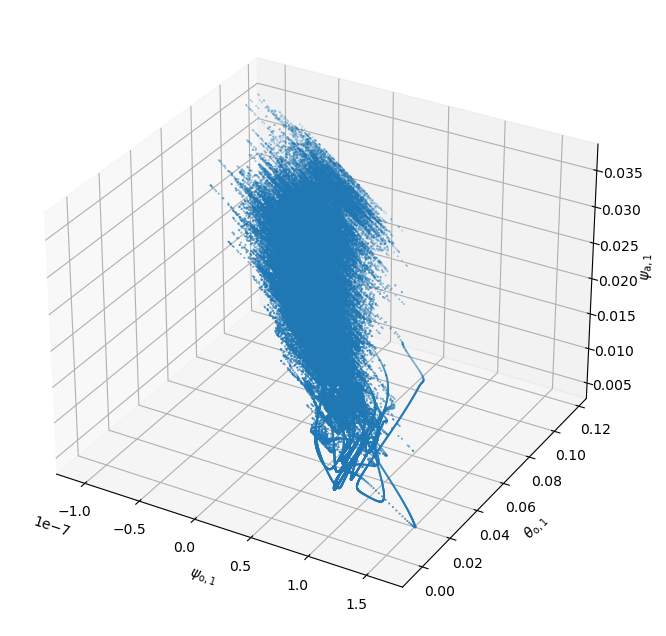

In [15]:
varx = 20
vary = 30
varz = 0

fig = plt.figure(figsize=(10, 8))
axi = fig.gca(projection='3d')

axi.scatter(traj[varx], traj[vary], traj[varz], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[varx]+'$')
axi.set_ylabel('$'+model_parameters.latex_var_string[vary]+'$')
axi.set_zlabel('$'+model_parameters.latex_var_string[varz]+'$');

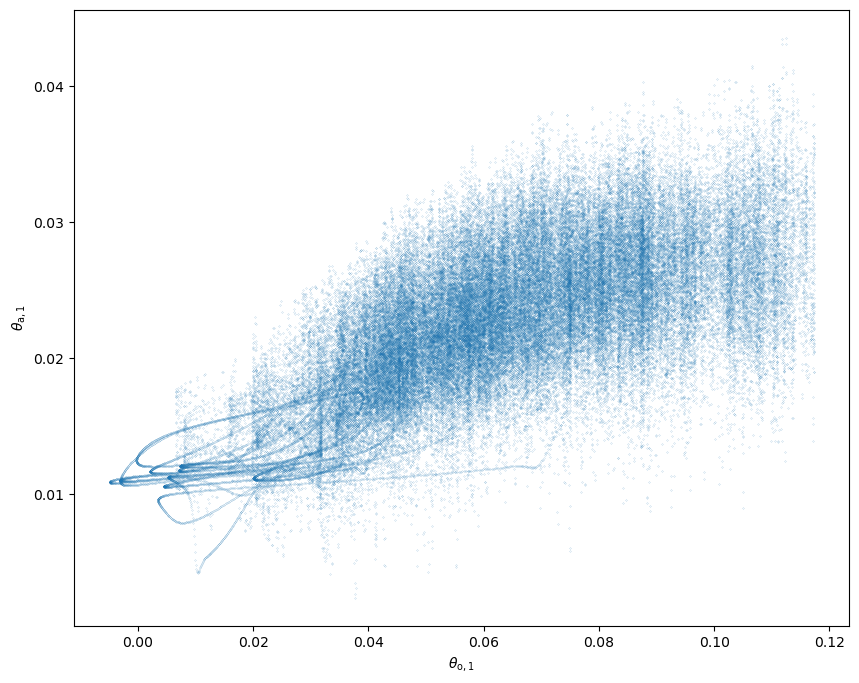

In [16]:
varx = 30
vary = 10
plt.figure(figsize=(10, 8))

plt.plot(traj[varx], traj[vary], marker='o', ms=0.1, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

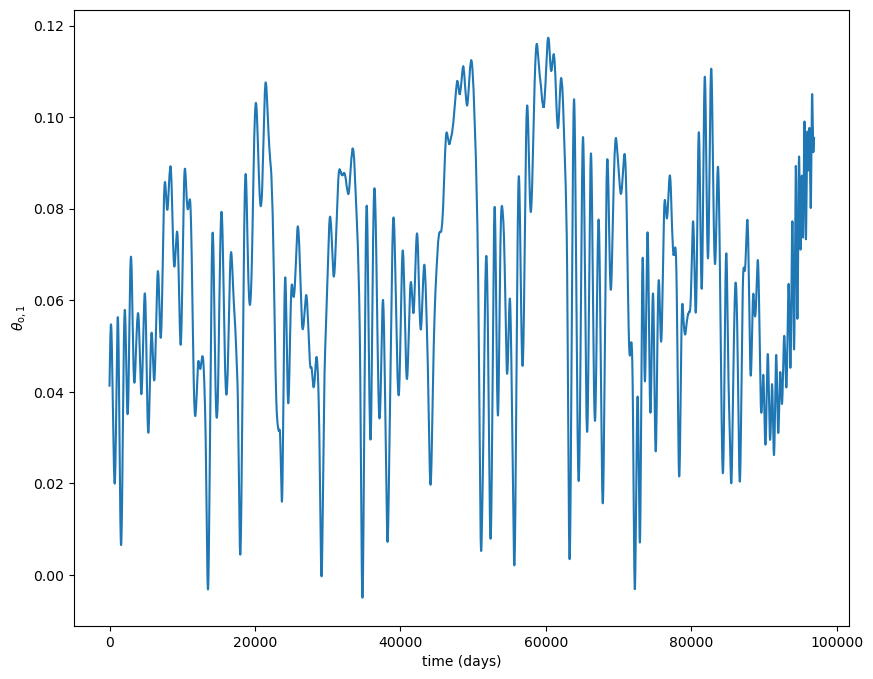

In [17]:
var = 30
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

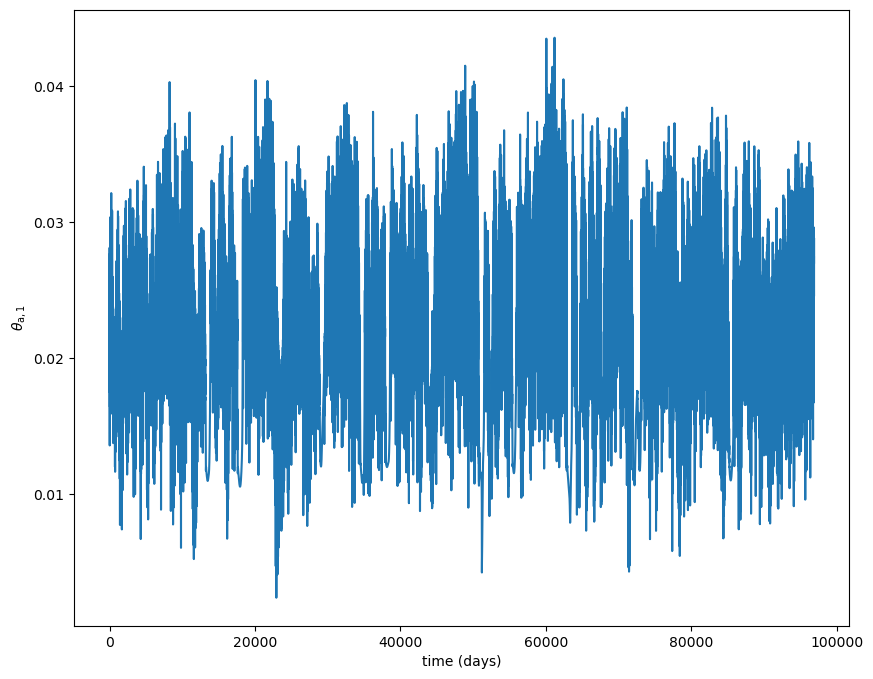

In [18]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

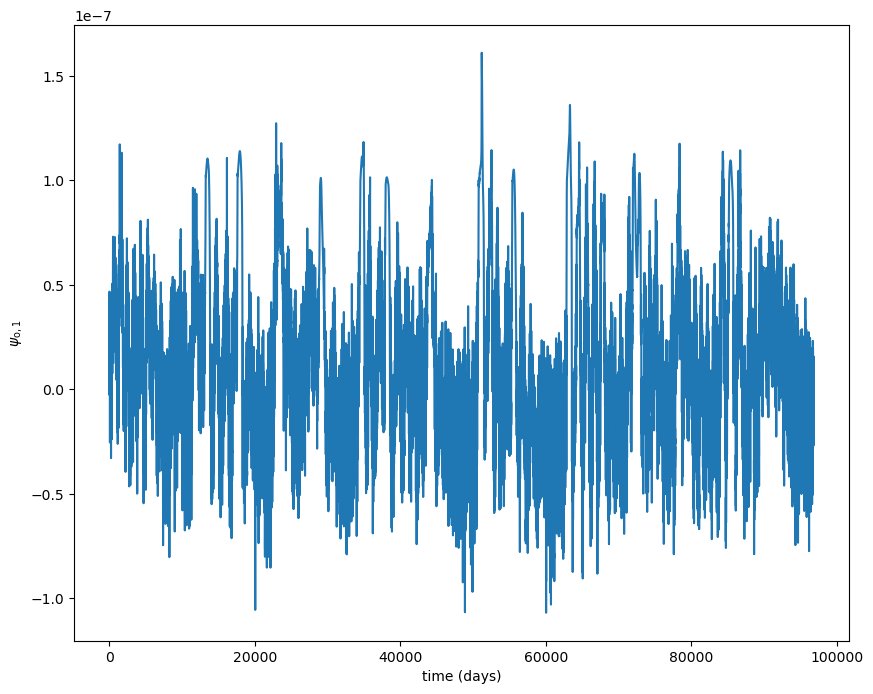

In [19]:
var = 20
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');